In [28]:
# ---- DEMO File ----
# ES170 Final Project

# Eric Puma  
# James Baskerville 
# Peter Seung Min Lee 
# Francisco Trujillo

# Prof. Prineha Narang
# Harvard University 2018


# IMPORTS =====================================================================

import numpy as np
from qutip import *
from scipy.optimize import minimize
import h5py
import matplotlib.pyplot as plt
import sys
import pickle
import time
import os
settings.auto_tidyup = False

# HELPER FUNCTIONS ============================================================

def save_obj(obj, name):
    with open('pickle/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('pickle/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

'''Returns the identity operator in a Hilbert Space off size n'''
def tenseye(n):
    return qeye([2] * n)

'''Returns the operator composed by a set of gates in a HS of size n'''
def gate_prod(n, gates):
    prod = tenseye(n)
    for gate in gates:
        prod = prod * gate
    return prod

'''Returns an operator corresponding tothe ZYZ rotations defined by 
angles in <params> applied only to the target qubit <tgt> in an 
Hilbert Space of dimension <n>'''
def rot(n, params, tgt):
    alpha, theta, beta = params
    return rz(alpha, n, tgt) * ry(theta, n, tgt) * rz(beta, n, tgt)

'''Returns an operator corresponding to a set of rotations conditional 
on the qubit <ctrl> defined by angles in <params> applied only to 
the target qubit <tgt> in an Hilbert Space of dimension <n>.'''
def ctrl_rot(n, params, ctrl, tgt):
    alpha, theta, beta = params
    A = rz(alpha, n, tgt) * ry(theta / 2.0, n, tgt)
    B = ry(-theta / 2.0, n, tgt) * rz(-(alpha + beta) / 2.0, n, tgt)
    C = rz((beta - alpha) / 2.0, n, tgt)    
    return A * cnot(n, ctrl, tgt) * B * cnot(n, ctrl, tgt) * C

'''Returns the number of gates and parameters needed for <n_qubits>.'''
def init_consts(n_qubits):
    n_gates = n_qubits ** 2 + n_qubits
    n_params = n_gates * 3
    return n_gates, n_params

'''Returns an array of size <n_params> initialized with <method>'''
def init_params(n_params, method=np.zeros):
    return method(n_params)

'''Returns three separate arrays representing the parameters 
for the first set of unitary rotations, the controlled rotations, 
and the last set of unitary rotations defined in <params> where
<n_qs> is the size of the circuit's Hilbert space.'''
def split_params(n_qs, params):
    return (params[:3*n_qs].reshape(n_qs, 3),
            params[3*n_qs:-3*n_qs].reshape(n_qs, n_qs-1, 3),
            params[-3*n_qs:].reshape(n_qs, 3))

'''Flattens and combines parameter arrays (undoes split_params)'''
def recombine_params(first, mid, last):
    return np.concatenate((first.flatten(), mid.flatten(), last.flatten()))



'''Returns an operator representing the parameterized individual rotations'''
def wrapper_gate(n, param_sets):
    if len(param_sets) != n:
        raise ValueError('The number of sets of params doesn\'t correspond to number of gates.')
    gates = []
    for tgt, rot_params in enumerate(param_sets):
        gates.append(rot(n, rot_params, tgt))
    return gate_prod(n, gates)

'''Returns an operator representing a set of parameterized controlled rotations'''
def blue_box_gate(n, params, ctrl):
    p_index = 0
    gates = []
    for tgt in range(n):
        if tgt != ctrl:
            rot_params = params[p_index]
            p_index += 1
            gates.append(ctrl_rot(n, rot_params, ctrl, tgt))
    return gate_prod(n, gates)

'''Returns an operator representing the whole circuit'''
def create_circuit_gate(n, all_params):
    params = np.array(all_params)
    gates = []
    
    # split parameters
    f, m, b = split_params(n, params)
    
    # front wrapper
    gates.append(wrapper_gate(n, f))
    
    # blue boxes
    for i in range(n):
        gates.append(blue_box_gate(n, m[i], i))
    
    # back wrapper
    gates.append(wrapper_gate(n, b))
    
    return gate_prod(n, gates)



In [30]:
# OPENFERMION DATA ============================================================

# Bond lengths for which we have precomputed hamiltonians

with h5py.File("bond_lengths.hdf5", "r") as f:
    try:
        dset = f['bond_lengths']
        bond_lengths = np.zeros(dset.shape)
        dset.read_direct(bond_lengths)
    except KeyError:
        print("Subgroup 'bond_lengths' not in 'bond_lengths.hdf5' data")
        
if type(bond_lengths) == type(None):
    print("Could not read bond lengths.")
else:
    bond_lengths = np.round(bond_lengths, 2)
    
hamiltonians = []

for bond_length in bond_lengths:
    hamiltonian = None
    
    # read hamiltonian from appropriate file
    with h5py.File("hamiltonians/sto-3g.{}.hdf5".format(round(bond_length, 2)), 'r') as f:
        try:
            dset = f['hamiltonian']
            hamiltonian = dset[()]
        except KeyError:
            print("subgroup `hamiltonian` not in `hamiltonians/{}` data".format(bond_length))
    
    if type(hamiltonian) == type(None):
        print("Couldn't read hamiltonian for bond length {}".format(bond_length, 2))
        continue
    
    # add hamiltonian to dictionary of hamiltonians
    hamiltonians.append(Qobj(hamiltonian, dims=[[2,2,2,2],[2,2,2,2]]))
    
hamiltonians = np.array(hamiltonians)

def get_groundstate(hamiltonian):
    return hamiltonian.groundstate()

groundstatize = np.vectorize(get_groundstate)

# Compute groundstates of molecular hamiltonians to use as training and testing data
groundenergies, groundstates = groundstatize(hamiltonians)

# plot hydrogen atom bond-length vs. ground-state energies
# red points are those states selected for training, everything else is for testing
# plt.plot(bond_lengths, groundenergies, 'ob-')
# #plt.plot(bond_lengths[training_indices], groundenergies[training_indices], 'or')
# plt.ylim([-1.2, -0.8])
# plt.xlim([0, 2.5])

In [31]:
# this probably exists in sklearn

def train_test_split(data, train_proportion, train_is=None):
    """ Divide data into training and test sets, using specific indices if given """
    train_sz = int(np.round(len(data) * train_proportion))
    training_indices, testing_indicies = [], []
    
    # use provided training indices, then fill in the rest
    if train_is is not None:
        training_indices = np.concatenate(
            (train_is, np.random.choice([i for i in np.arange(len(data)) if i not in train_is], 
                                        train_sz - len(train_is), replace=False)))
    else:
        training_indices = np.random.choice(np.arange(len(data)), train_sz, replace=False)
    
    testing_indicies = np.array([i for i in range(len(data)) if i not in training_indices])
    return data[training_indices], data[testing_indicies]

def gen_dmify():
    return np.vectorize(ket2dm)

def gen_encodify(U):
    return np.vectorize(lambda dm: U * dm * U.dag())

def gen_ptracify(sel):
    return np.vectorize(lambda dm: dm.ptrace(sel))

def gen_fidelify(tr_dm):
    return np.vectorize(lambda dm: fidelity(dm, tr_dm))

# Cost function implementation from the paper:
def cost(params, psi_set, n, k, sel, debug=False):
    n_states = len(psi_set)
    trashdm = ket2dm(tensor([basis(2,0) for _ in range(k)]))

    U = create_circuit_gate(n + k, params)

    dmify = gen_dmify()
    encodify = gen_encodify(U)
    ptracify = gen_ptracify(sel)
    fidelify = gen_fidelify(trashdm)

    # turn each state in the training set into a density matrix
    dms = dmify(psi_set)
    
    # encode dms
    encoded_dms = encodify(dms)

    # Apply the encode/decode transformation and get the partial trace
    ptrace_dms = ptracify(encoded_dms)  

    # get fidelities
    fidelities = fidelify(ptrace_dms)
    
    if debug:
        print("parameters:", params)
        print("compression dimension ; trash dimension:", n, ";", k)
        print("partial trace (trash) qubits:", sel)
        print("number of input states:", n_states)
        matrix_histogram(ptrace_dms[n_states - 1])
        plt.show()
        print("fidelities:", fidelities)
        print ("cost", 1 - np.sum(fidelities) / n_states)
    
    # compute cost, with probability weights equal
    # print ("cost", 1 - np.sum(fidelities) / n_states)
    return 1 - (np.sum(fidelities) / n_states)

class CostInfo():
    """
    Makes use of the 'cost' function as a method of a class that keeps track of
    the cost at each iteration
    """
    def __init__(self):
        self.costs = []
        
    def class_cost(self, params, psi_set, n, k, sel, debug=False):
        cost_res = cost(params, psi_set, n, k, sel, debug)
        self.costs.append(cost_res)
        return cost_res

def viz_dm(res_fns, num, i=3):
    opt_res = load_obj(res_fns[num][:-4])
    costs = opt_res['costs']
    params = opt_res['x']
    sel = opt_res['sel']
    
    U = create_circuit_gate(n=4, all_params=params)
    dm = U*ket2dm(train_set[i])*U.dag()
    hinton(dm.ptrace([j for j in range(4) if j not in sel]))
    plt.show()

def viz_data(res_fns, num, save=False):
    opt_res = load_obj(res_fns[num][:-4])
    if save and not os.path.isdir('img/res{}'.format(num)):
        os.mkdir('img/res{}'.format(num))
        
    costs = opt_res['costs']
    params = opt_res['x']
    sel = opt_res['sel']
    
    plt.plot(costs, '', linewidth=3, color='blue')
    plt.grid(True, which='major')
    plt.semilogy()
    if save:
        plt.savefig('img/res{}/costplot.png'.format(num), dpi=300,  bbox_inches='tight')
    else:
        plt.show()
    plt.close()
    
    U = create_circuit_gate(n=4, all_params=params)
    for i in range(len(train_set)):
        dm = U*ket2dm(train_set[i])*U.dag()
        ptrace_dm = dm.ptrace([j for j in range(4) if j not in sel])
        matrix_histogram(ptrace_dm, xlabels=range(1,5), ylabels=range(1,5))
        if save:
            plt.savefig('img/res{}/hist-{}.png'.format(num, i), dpi=300, bbox_inches='tight')
        else:
            plt.show()
#         hinton(ptrace_dm, xlabels=range(1,5), ylabels=range(1,5))
#         if save:
#             plt.savefig('img/res{}/hint-{}.png'.format(num, i), dpi=300, bbox_inches='tight')
#         else:
#             plt.show()
   
    plt.close('all')

In [32]:
n_gates, n_params = init_consts(4)

# same training states as those in the paper
lens = [7, 11, 16, 24, 33, 41]
train_set = np.array(groundstates)[lens]
test_set = np.array(groundstates)[[i for i in range(len(groundstates)) if i not in lens]]

method = 'L-BFGS-B'
sel = [0,2]

for _ in range(1):
    try:
        # always initialize new class in the beginning to initialize empty cost array attribute
        ci = CostInfo()
        # initialize new random parameters for variability
        initial_params = init_params(n_params, lambda x: np.random.rand(x)*2*np.pi)
        # initial_params = init_params(n_params, lambda x: np.random.rand(x)*2*np.pi)

        print ("Iteration: {}".format(iters))

        # use the class method cost function so that costs are logged internally in the class
        res = minimize(ci.class_cost, initial_params, args=(train_set, 2, 2, sel, False), method=method, bounds=[[0, 4*np.pi]] * n_params, options={'eps': 1e-03, 'ftol': 0.1})
        params = res['x']

        final_result = res
        
        # save costs and selection as part of the result
        final_result["costs"] = ci.costs
        final_result["sel"] = sel
        
        
        # save results for later analysis
        save_obj(final_result, 'demoobject')
        
    except KeyboardInterrupt:
        sys.exit()
        

Iteration: 1


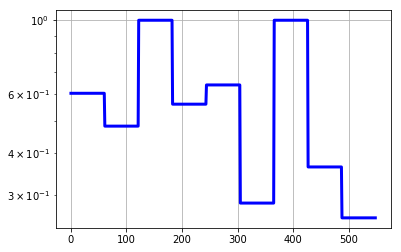

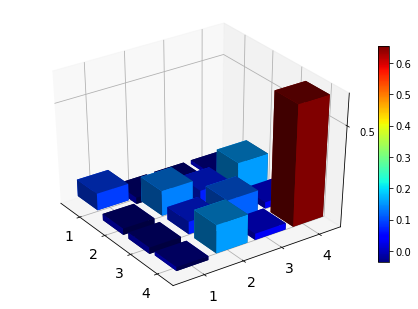

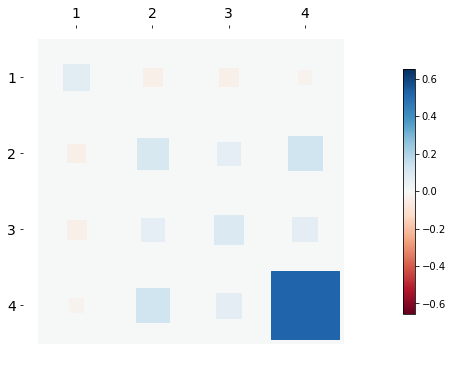

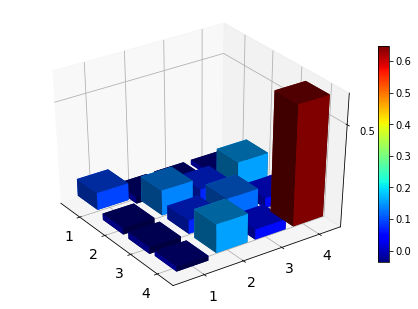

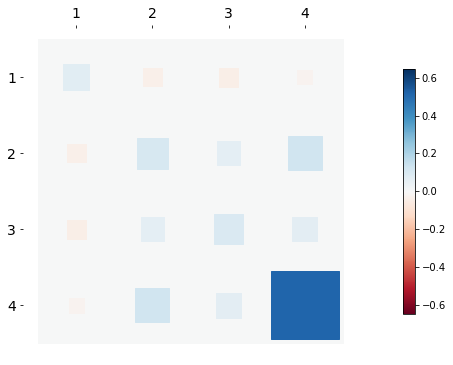

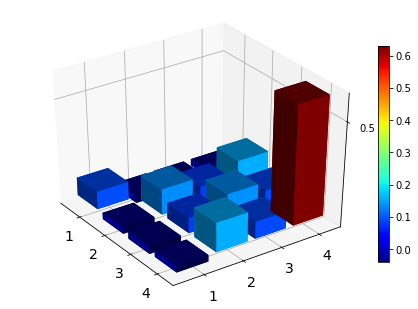

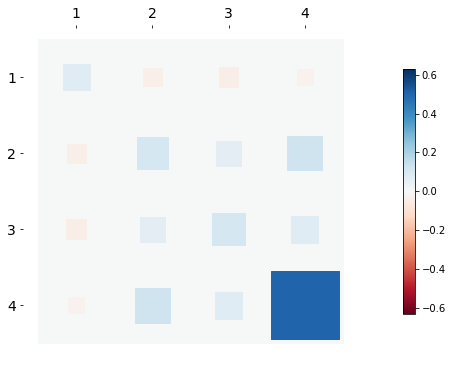

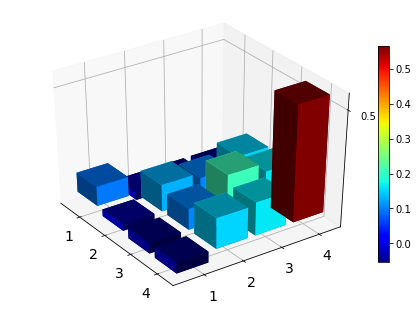

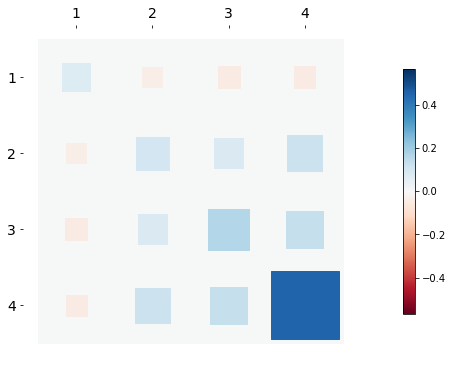

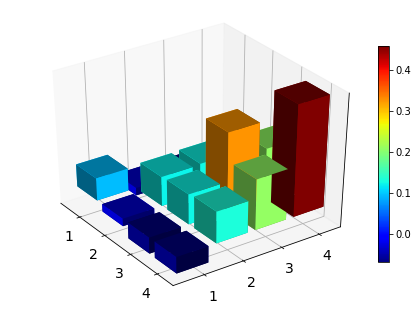

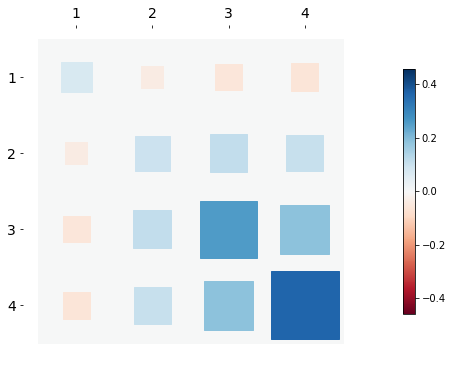

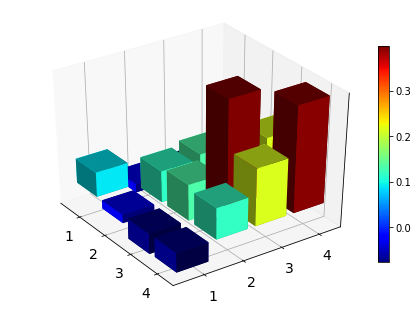

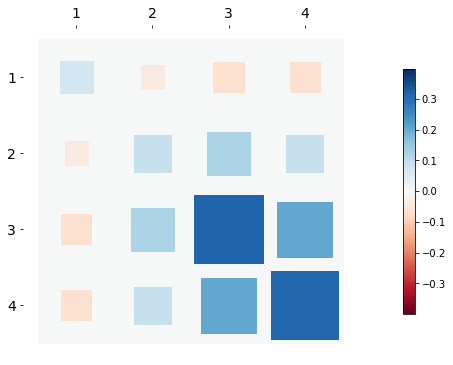

In [33]:
viz_data(["demoobject.pkl"],0)

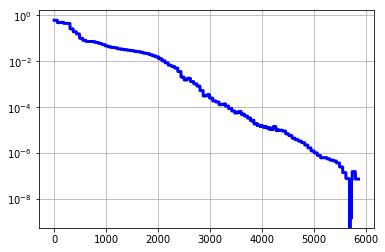

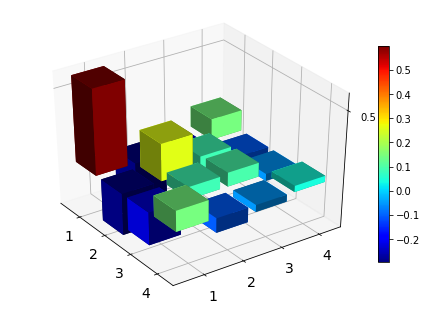

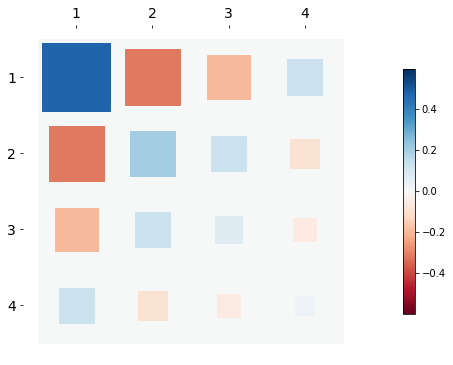

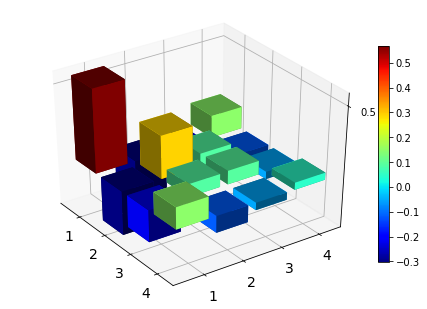

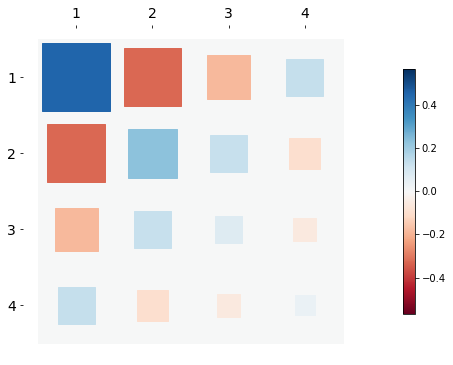

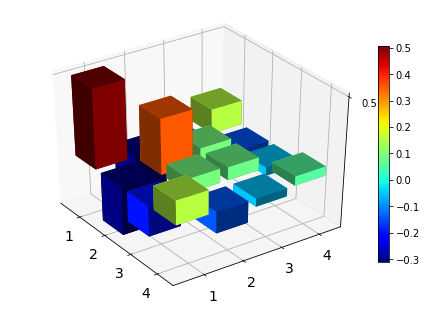

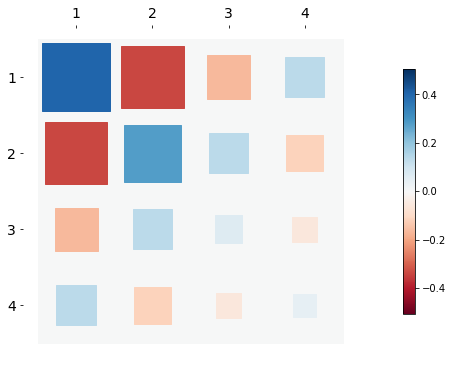

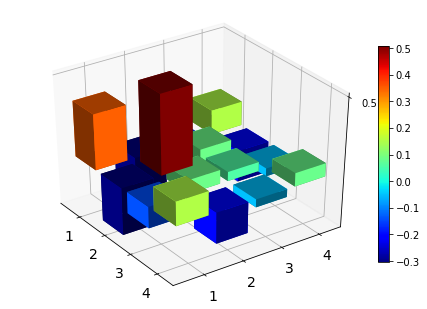

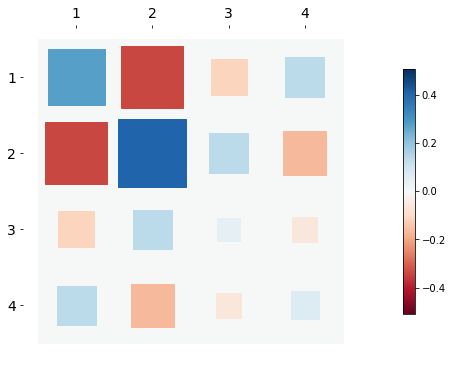

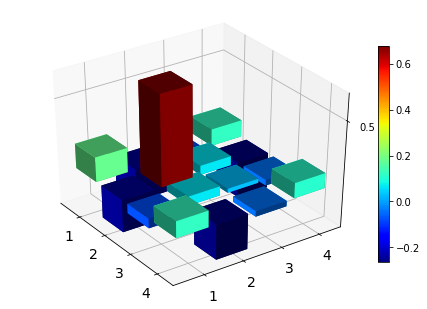

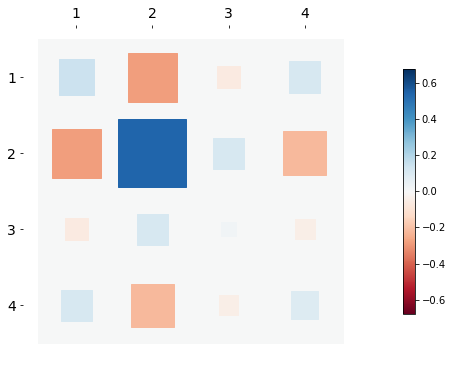

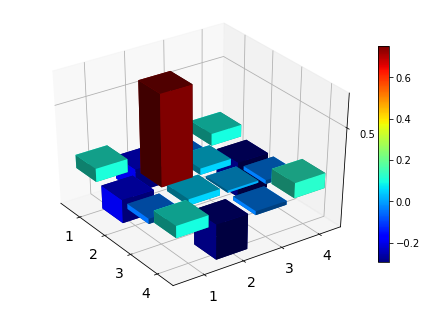

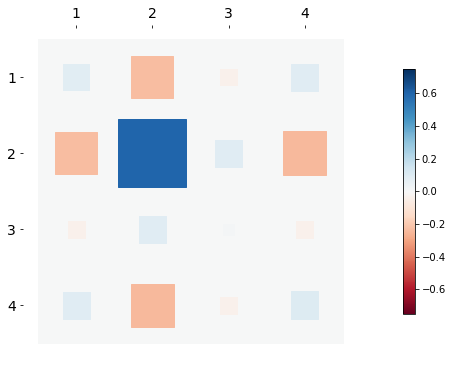

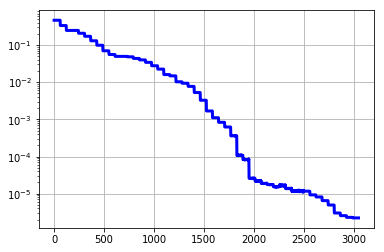

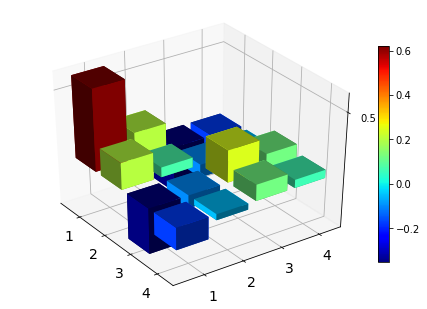

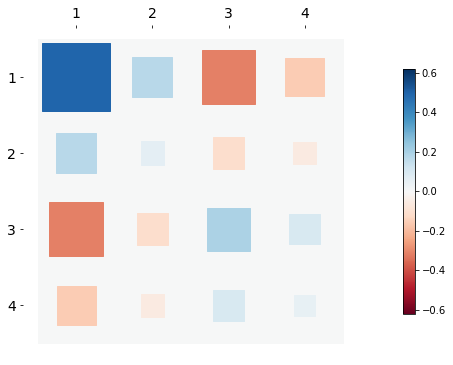

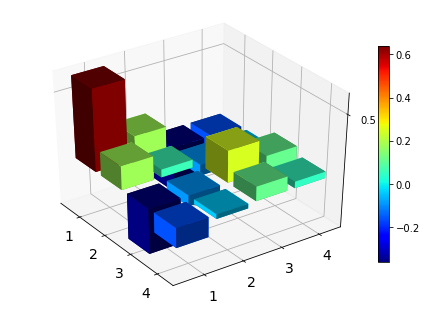

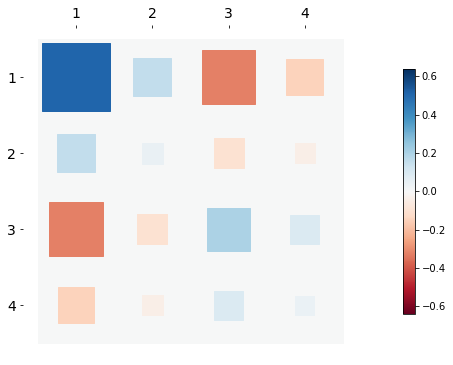

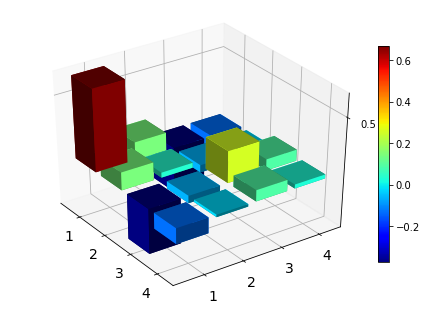

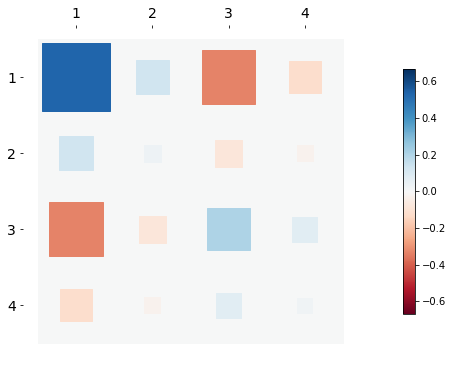

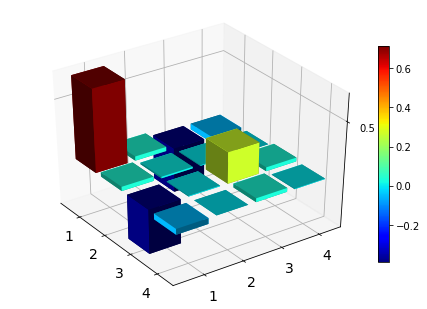

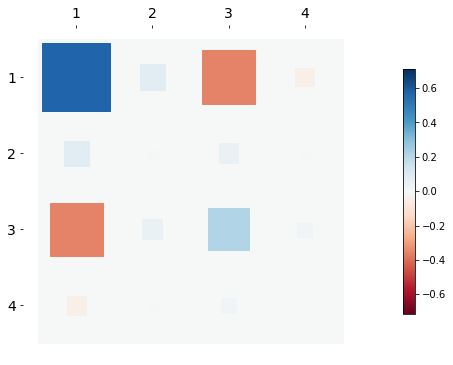

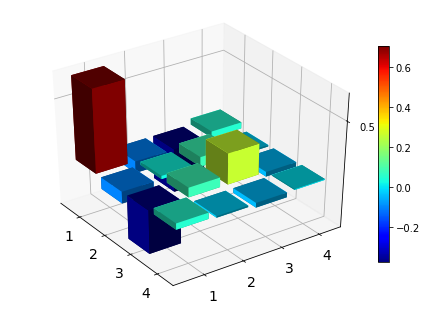

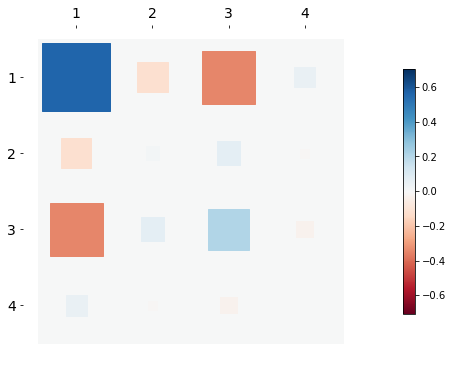

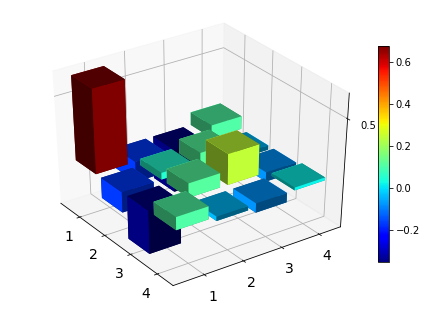

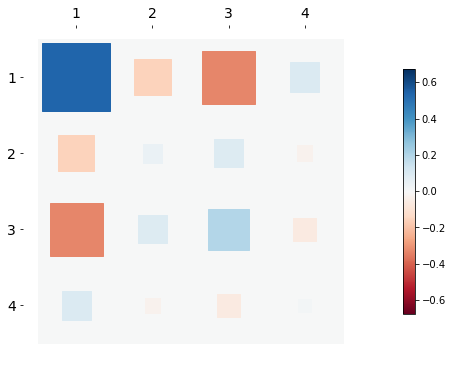

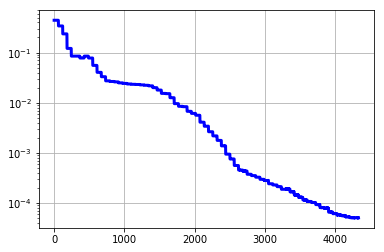

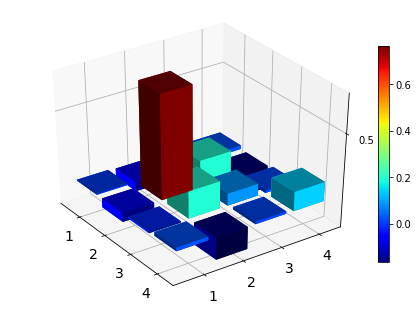

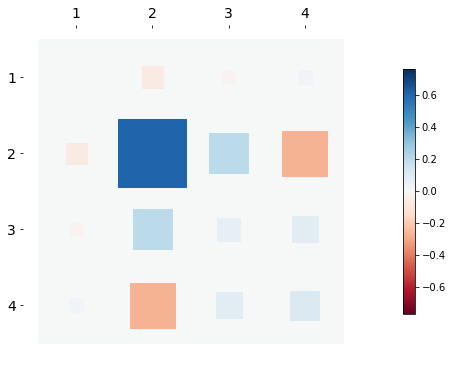

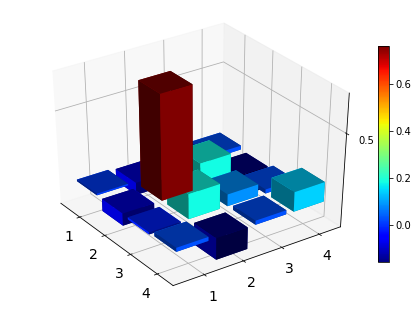

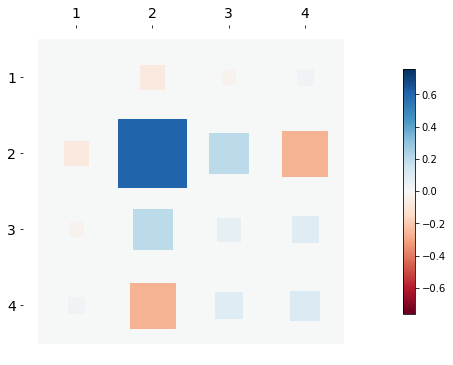

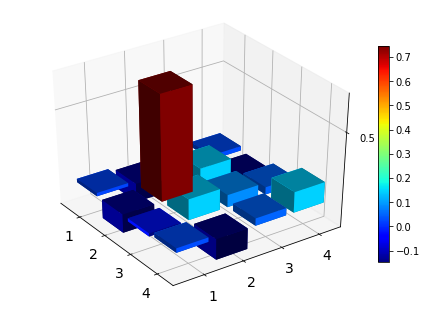

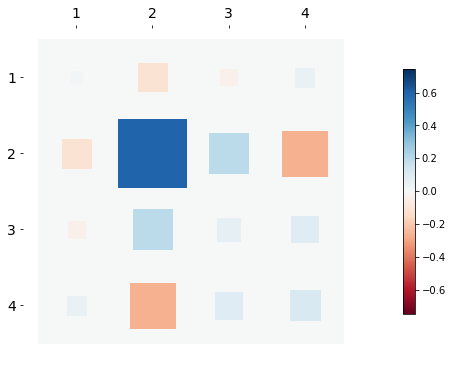

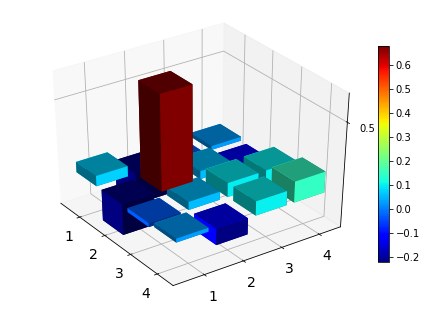

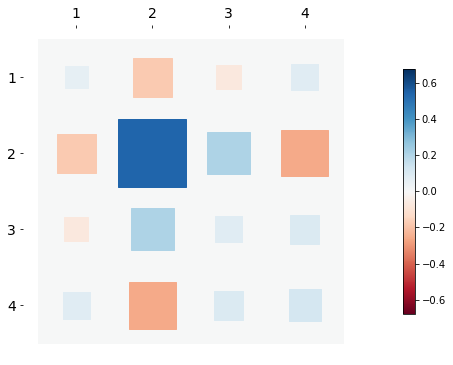

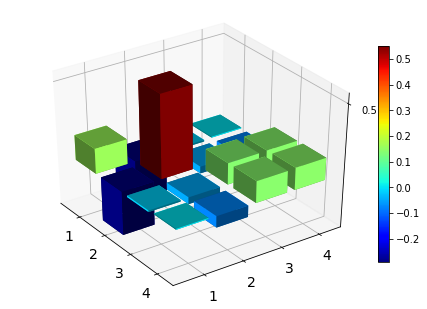

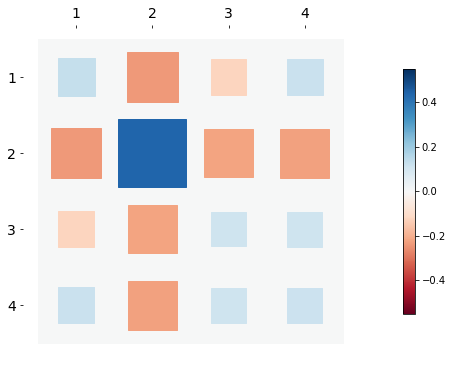

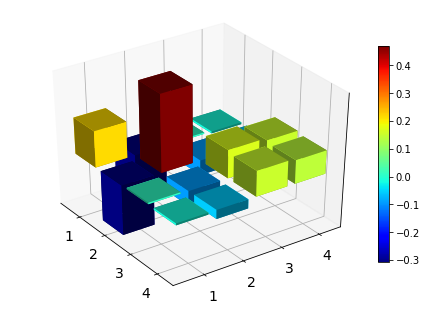

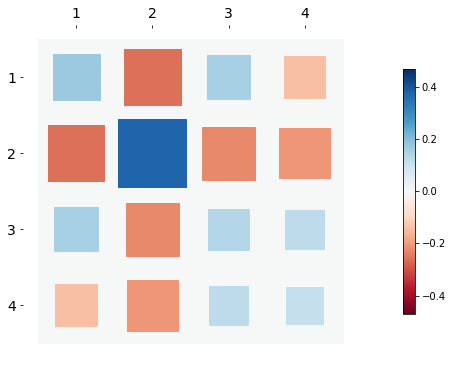

In [34]:
result_filenames = list(filter(lambda f: f.startswith('run2'), os.listdir('pickle')))

for i in [4, 7, 9]:
        viz_data(result_filenames, i, save=False)